In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import config

import torch
import datasets
import numpy as np

from torch.nn import functional as F
from torchvision.transforms import v2
from datasets import load_dataset

#datasets.config.DOWNLOADED_DATASETS_PATH='./datasets'
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
True


In [49]:
input_dim = 128
num_layers = 8
batch_size = 32

dropout = 0.0
max_lr = 1e-3
wd = 0.05
path = './'
epoches = config.num_epoches
warmup_steps = 2000


transforms = v2.Compose([
    #v2.PILToTensor(),
    v2.RandomResizedCrop(64, scale=(0.7, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomRotation(15),
    #v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    # v2.Normalize(mean=[0.478], std=[0.268]),
    # v2.RandomErasing(),
    # v2.RandAugment(),
])

eval_transforms = v2.Compose([
    v2.PILToTensor(),
    #v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),

])

cutmix = v2.CutMix(num_classes=config.num_classes)
mixup = v2.MixUp(num_classes=config.num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


In [87]:
# Load dataset
from Dataset import CustomImageDataSet, load_data

train_x, train_y, val_x, val_y = load_data(config)
train_dataset, val_dataset = CustomImageDataSet(train_x, transform=transforms), CustomImageDataSet(val_x, transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)

In [51]:
# initialize model
import torchvision
from models.Vit import ViT
model = torchvision.models.VisionTransformer(image_size=64, num_classes=200, patch_size=16, num_layers=8, num_heads=8, hidden_dim=512, mlp_dim=1024).cuda()
model = ViT(image_size=64, num_classes=200, patch_size=16, num_layers=8, num_heads=8, hidden_dim=512, mlp_dim=1024).cuda()
#model = torchvision.models.vit_b_16(image_size=64, num_classes=200,).cuda()

In [ ]:
# Pre-train the model with proxy-task of simple reconstruction
# dataset
train_dataset, val_dataset = CustomImageDataSet(train_x, transform=transforms), CustomImageDataSet(val_x, transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)
total_train_steps = len(train_x) * epoches

import math
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'number of param: {num_params}')
print(f'number of iters: {len(train_dataloader)}')

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd)
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(0.9, 0.98))
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_train_steps-warmup_steps, eta_min=max_lr*0.01)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], [warmup_steps])

test_name = f"{config.dataset}_vit_{config.num_epoches}_reconstruction"
# test_name = 'cnn_4_stage'
writer = SummaryWriter(path+'/runs/'+test_name, max_queue=120)
scaler = torch.cuda.amp.GradScaler()
train_step = 0
best_loss = float('inf')
for epoch in range(epoches):

    losses = []
    model.train()
    print("Epoch {}: ".format(epoch))
    print("Loading data...")
    for img, label in train_dataloader:
        print("Finished loading data.")
        img = img.cuda()
        label = label.cuda()
        batch_loss = 0
        model.train()
        # for mini_data in data.chunk(num_mini_batches, 0):
        with torch.autocast(device_type="cuda"):
            output = model.reconstruct(img)
            loss = F.mse_loss(output, label) 

        batch_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
        writer.add_scalar('Loss/train', batch_loss, train_step)
        losses.append(batch_loss)

        train_step += 1

    avg_loss = sum(losses)/len(losses)
    print("Average train loss: ".format(avg_loss))
    writer.add_scalar('Loss/train_average', avg_loss, epoch)

    #losses.clear()
    #model.eval()
    """ for img, label in valid_dataloader:

        img = img.cuda()
        label = label.cuda()
        with torch.inference_mode(), torch.autocast(device_type="cuda"):
            
            output = model.reconstruct(img)  
            #final_target = torch.reshape(label, (-1,))
            loss = F.mse_loss(output, label, reduction='none')

            pred_labels = output.argmax(1)
            acc = (pred_labels==label).float().mean()


        losses.append(loss.cpu().numpy())
    
    
    avg_loss = np.mean(np.concatenate(losses, 0)).item()
    writer.add_scalar('Loss/valid', avg_loss, epoch)
    losses.clear() 
    
    if avg_loss <= best_loss:
        print(avg_loss)
        best_loss = avg_loss
        torch.save(model.state_dict(), path+'/runs/'+test_name+'/best_model.pt')
    """

    

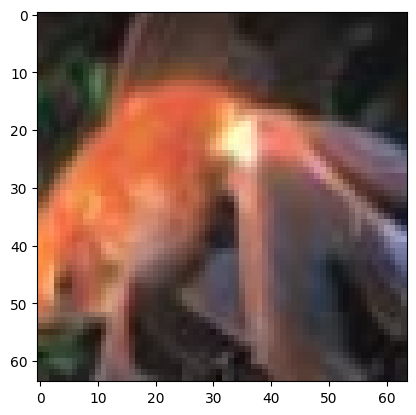

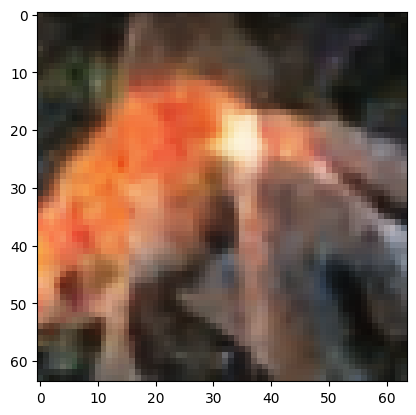

In [60]:
#test
import matplotlib.pyplot as plt
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd)
for img, label in val_dataloader:
    label = label.cuda()
    im = img.cuda()
    output = model.reconstruct(im)
    loss = F.mse_loss(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    output = output[0].permute(1,2,0).detach().cpu().numpy()#.astype(np.int32)
    im = im[0].detach().cpu().permute(1,2,0).numpy()#.astype(np.int32)
    plt.imshow(im)
    plt.show()
    plt.imshow(output)
    plt.show()

In [88]:
# dataset for prediction
train_dataset, val_dataset = CustomImageDataSet(train_x, train_y, transform=transforms), CustomImageDataSet(val_x, val_y, transform=None)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)

total_train_steps = len(train_x) * epoches

In [ ]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('model_scripted.pt')
#torch.save(model.state_dict(), 'pre_trained/vit/1.pt')
#pt_model = model

In [68]:
# new untrained model
model = ViT(image_size=64, num_classes=200, patch_size=16, num_layers=8, num_heads=8, hidden_dim=512, mlp_dim=1024).cuda()

In [ ]:
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'number of param: {num_params}')
print(f'number of iters: {len(train_dataloader)}')

from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd)
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(0.9, 0.98))

scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_train_steps-warmup_steps, eta_min=max_lr*0.01)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], [warmup_steps])

# %%
import math

from torch.utils.tensorboard import SummaryWriter

test_name = f"{config.dataset}_vit_{config.num_epoches}_direction_{config.ssm_direction}"
# test_name = 'cnn_4_stage'
writer = SummaryWriter(path+'/runs/'+test_name, max_queue=120)

scaler = torch.cuda.amp.GradScaler()

train_step = 0


best_loss = float('inf')
for epoch in range(epoches):
    losses = []
    model.train()
    #indices = torch.randperm(train_x.shape[0])
    for img, label in train_dataloader:
        #img, label = train_x[indices[i:i+batch_size]], train_y[indices[i:i+batch_size]]
        img = img.cuda()
        label = label.cuda()
        #img, label = cutmix_or_mixup(img, label)
        batch_loss = 0
        model.train()
        # for mini_data in data.chunk(num_mini_batches, 0):
        with torch.autocast(device_type="cuda"):
            output = model(img)
            final_output = torch.reshape(output, (-1, output.shape[-1]))
            loss = F.cross_entropy(final_output, label) 

        batch_loss += loss.item()

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e2)

        scaler.step(optimizer)

        scaler.update()
 
        scheduler.step()
        optimizer.zero_grad()

        writer.add_scalar('Loss/train', batch_loss, train_step)
        losses.append(batch_loss)

        train_step += 1

    avg_loss = sum(losses)/len(losses)
    print(f'\n Epoch {epoch} train loss: {avg_loss}')
    writer.add_scalar('Loss/train_average', avg_loss, epoch)


    
    losses.clear()
    accs = []
    model.eval()
    for img, label in val_dataloader:
        img = img.cuda()
        label = label.cuda()
        with torch.inference_mode(), torch.autocast(device_type="cuda"):
            
            output = model(img)
            final_target = torch.reshape(label, (-1,))
            loss = F.cross_entropy(output, final_target, reduction='none')
            
            pred_labels = output.argmax(1)
            acc = (pred_labels==label).float().mean()
            accs.append(acc)


        losses.append(loss.cpu().numpy())
    
    avg_loss = np.mean(np.concatenate(losses, 0)).item()
    avg_acc= sum(accs) / len(accs)
    print(f'\n Epoch {epoch} validation acc: {avg_acc}')

    writer.add_scalar('Loss/valid', avg_loss, i)

    writer.add_scalar('Acc/valid', avg_acc, i)


    losses.clear()

    if avg_loss <= best_loss:
        print(avg_loss)
        best_loss = avg_loss
        torch.save(model.state_dict(), path+'/runs/'+test_name+'/best_model.pt')

In [92]:
#
from_scratch = model
model = pt_model

In [93]:
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'number of param: {num_params}')
print(f'number of iters: {len(train_dataloader)}')

from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd)
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(0.9, 0.98))

scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_train_steps-warmup_steps, eta_min=max_lr*0.01)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [scheduler1, scheduler2], [warmup_steps])

# %%
import math

from torch.utils.tensorboard import SummaryWriter

test_name = f"{config.dataset}_vit_{config.num_epoches}_direction_{config.ssm_direction}"
# test_name = 'cnn_4_stage'
writer = SummaryWriter(path+'/runs/'+test_name, max_queue=120)

scaler = torch.cuda.amp.GradScaler()

train_step = 0


best_loss = float('inf')
for epoch in range(epoches):
    losses = []
    model.train()
    #indices = torch.randperm(train_x.shape[0])
    for img, label in train_dataloader:
        #img, label = train_x[indices[i:i+batch_size]], train_y[indices[i:i+batch_size]]
        img = img.cuda()
        label = label.cuda()
        #img, label = cutmix_or_mixup(img, label)
        batch_loss = 0
        model.train()
        # for mini_data in data.chunk(num_mini_batches, 0):
        with torch.autocast(device_type="cuda"):
            output = model(img)
            final_output = torch.reshape(output, (-1, output.shape[-1]))
            loss = F.cross_entropy(final_output, label) 

        batch_loss += loss.item()

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e2)

        scaler.step(optimizer)

        scaler.update()
 
        scheduler.step()
        optimizer.zero_grad()

        writer.add_scalar('Loss/train', batch_loss, train_step)
        losses.append(batch_loss)

        train_step += 1

    avg_loss = sum(losses)/len(losses)
    print(f'\n Epoch {epoch} train loss: {avg_loss}')
    writer.add_scalar('Loss/train_average', avg_loss, epoch)


    
    losses.clear()
    accs = []
    model.eval()
    for img, label in val_dataloader:
        img = img.cuda()
        label = label.cuda()
        with torch.inference_mode(), torch.autocast(device_type="cuda"):
            
            output = model(img)
            final_target = torch.reshape(label, (-1,))
            loss = F.cross_entropy(output, final_target, reduction='none')
            
            pred_labels = output.argmax(1)
            acc = (pred_labels==label).float().mean()
            accs.append(acc)


        losses.append(loss.cpu().numpy())
    
    avg_loss = np.mean(np.concatenate(losses, 0)).item()
    avg_acc= sum(accs) / len(accs)
    print(f'\n Epoch {epoch} validation acc: {avg_acc}')

    writer.add_scalar('Loss/valid', avg_loss, i)

    writer.add_scalar('Acc/valid', avg_acc, i)


    losses.clear()

    if avg_loss <= best_loss:
        print(avg_loss)
        best_loss = avg_loss
        torch.save(model.state_dict(), path+'/runs/'+test_name+'/best_model.pt')

number of param: 34225291
number of iters: 6137


d:\xie\Vision\ViT\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
d:\xie\Vision\ViT\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://g


 Epoch 0 train loss: 5.180237956829484

 Epoch 0 validation acc: 0.04603658616542816
4.7902045249938965

 Epoch 1 train loss: 4.606016997271608

 Epoch 1 validation acc: 0.07205284386873245
4.511613845825195

 Epoch 2 train loss: 4.431593119797031

 Epoch 2 validation acc: 0.09878048300743103
4.324558734893799

 Epoch 3 train loss: 4.314900493590747

 Epoch 3 validation acc: 0.11615853756666183
4.232433795928955

 Epoch 4 train loss: 4.222218315473534

 Epoch 4 validation acc: 0.12154471129179001
4.1840949058532715

 Epoch 5 train loss: 4.146213893492563

 Epoch 5 validation acc: 0.1336382031440735
4.084181308746338

 Epoch 6 train loss: 4.093706667724331

 Epoch 6 validation acc: 0.13932926952838898
4.07025671005249

 Epoch 7 train loss: 4.0525148680219045

 Epoch 7 validation acc: 0.13810975849628448
4.0505452156066895

 Epoch 8 train loss: 4.008689122730694

 Epoch 8 validation acc: 0.14786584675312042
4.019979000091553

 Epoch 9 train loss: 3.9841619826924903

 Epoch 9 validation 